In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

In [2]:
# Load datasets
data_players = pd.read_csv('datasets/dota-2-matches/players.csv')
data_matches = pd.read_csv('datasets/dota-2-matches/match.csv')

In [3]:
# Separates out the list of hero_ids for radiant and dire teams
def get_radiant_heros(df):
    teams_data = []
    for j in range(df.shape[0]):
        row = []
        for _ in range(5):
            row.append(df[j].pop(df[j].index(df[j][0])))
        teams_data.append(row)
    return pd.DataFrame(np.array(teams_data).reshape(50000, 5), columns=["rad_hero_1", "rad_hero_2", "rad_hero_3", "rad_hero_4", "rad_hero_5"])

dire_data = data_players.groupby('match_id')['hero_id'].apply(list)
radiant_data = get_radiant_heros(dire_data)
dire_data_pd = pd.DataFrame(columns=["dir_hero_1", "dir_hero_2", "dir_hero_3", "dir_hero_4", "dir_hero_5"])
for i in range(dire_data.shape[0]):
    dire_data_pd = pd.concat([dire_data_pd, 
                              pd.DataFrame(
                                  np.array(dire_data[i]).reshape(1,5), 
                                  columns=["dir_hero_1", "dir_hero_2", "dir_hero_3", "dir_hero_4", "dir_hero_5"])], 
                             ignore_index=True)

In [4]:
# Add team hero data to match data
data_matches = pd.concat([data_matches, radiant_data, dire_data_pd], axis=1)

# Drop unused columns
data_matches = data_matches.drop(columns=['start_time','duration','game_mode','positive_votes','negative_votes','cluster'])
data_matches.head()

,match_id,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,radiant_win,rad_hero_1,rad_hero_2,rad_hero_3,rad_hero_4,rad_hero_5,dir_hero_1,dir_hero_2,dir_hero_3,dir_hero_4,dir_hero_5
0,0,1982,4,3,63,1,True,86,51,83,11,67,106,102,46,7,73
1,1,0,1846,63,0,221,False,7,82,71,39,21,73,22,5,67,106
2,2,256,1972,63,48,190,False,51,109,9,41,27,38,7,10,12,85
3,3,4,1924,51,3,40,False,50,44,32,26,39,78,19,31,40,47
4,4,2047,0,0,63,58,True,8,39,55,87,69,101,100,22,67,21


In [5]:
# Filter out numerical data to calculate summary statistic (mean)
filtered_data = data_players[['match_id', 'gold_spent','gold_per_min','xp_per_min','kills','deaths','tower_damage','hero_damage']]

# Separate data for radiant and dire
radiants = filtered_data[data_players['player_slot'] < 5]
dires = filtered_data[data_players['player_slot'] > 5]

# Calculate the mean of the metrics
rad_mean = radiants.groupby('match_id').mean()
rad_mean = rad_mean.add_suffix('_radiant')
dire_mean = dires.groupby('match_id').mean()
dire_mean = dire_mean.add_suffix('_dire')

# Add to matches dataset
data_matches = pd.concat([data_matches, dire_mean, rad_mean], axis=1)
data_matches.head()

,match_id,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,radiant_win,rad_hero_1,rad_hero_2,rad_hero_3,...,deaths_dire,tower_damage_dire,hero_damage_dire,gold_spent_radiant,gold_per_min_radiant,xp_per_min_radiant,kills_radiant,deaths_radiant,tower_damage_radiant,hero_damage_radiant
0,0,1982,4,3,63,1,True,86,51,83,...,10.4,510.0,9431.0,17449.0,480.6,554.6,10.0,3.4,1770.6,17045.2
1,1,0,1846,63,0,221,False,7,82,71,...,7.4,2229.6,18663.2,13862.0,392.6,458.8,7.0,10.6,484.0,11716.8
2,2,256,1972,63,48,190,False,51,109,9,...,4.4,1598.0,12251.6,10998.0,286.2,321.2,4.4,9.8,377.2,9208.6
3,3,4,1924,51,3,40,False,50,44,32,...,13.0,1861.8,21476.4,15337.0,396.2,520.6,12.8,13.2,920.8,17303.0
4,4,2047,0,0,63,58,True,8,39,55,...,7.4,9.0,10012.8,15796.0,567.0,519.8,7.4,3.2,2612.4,11552.0


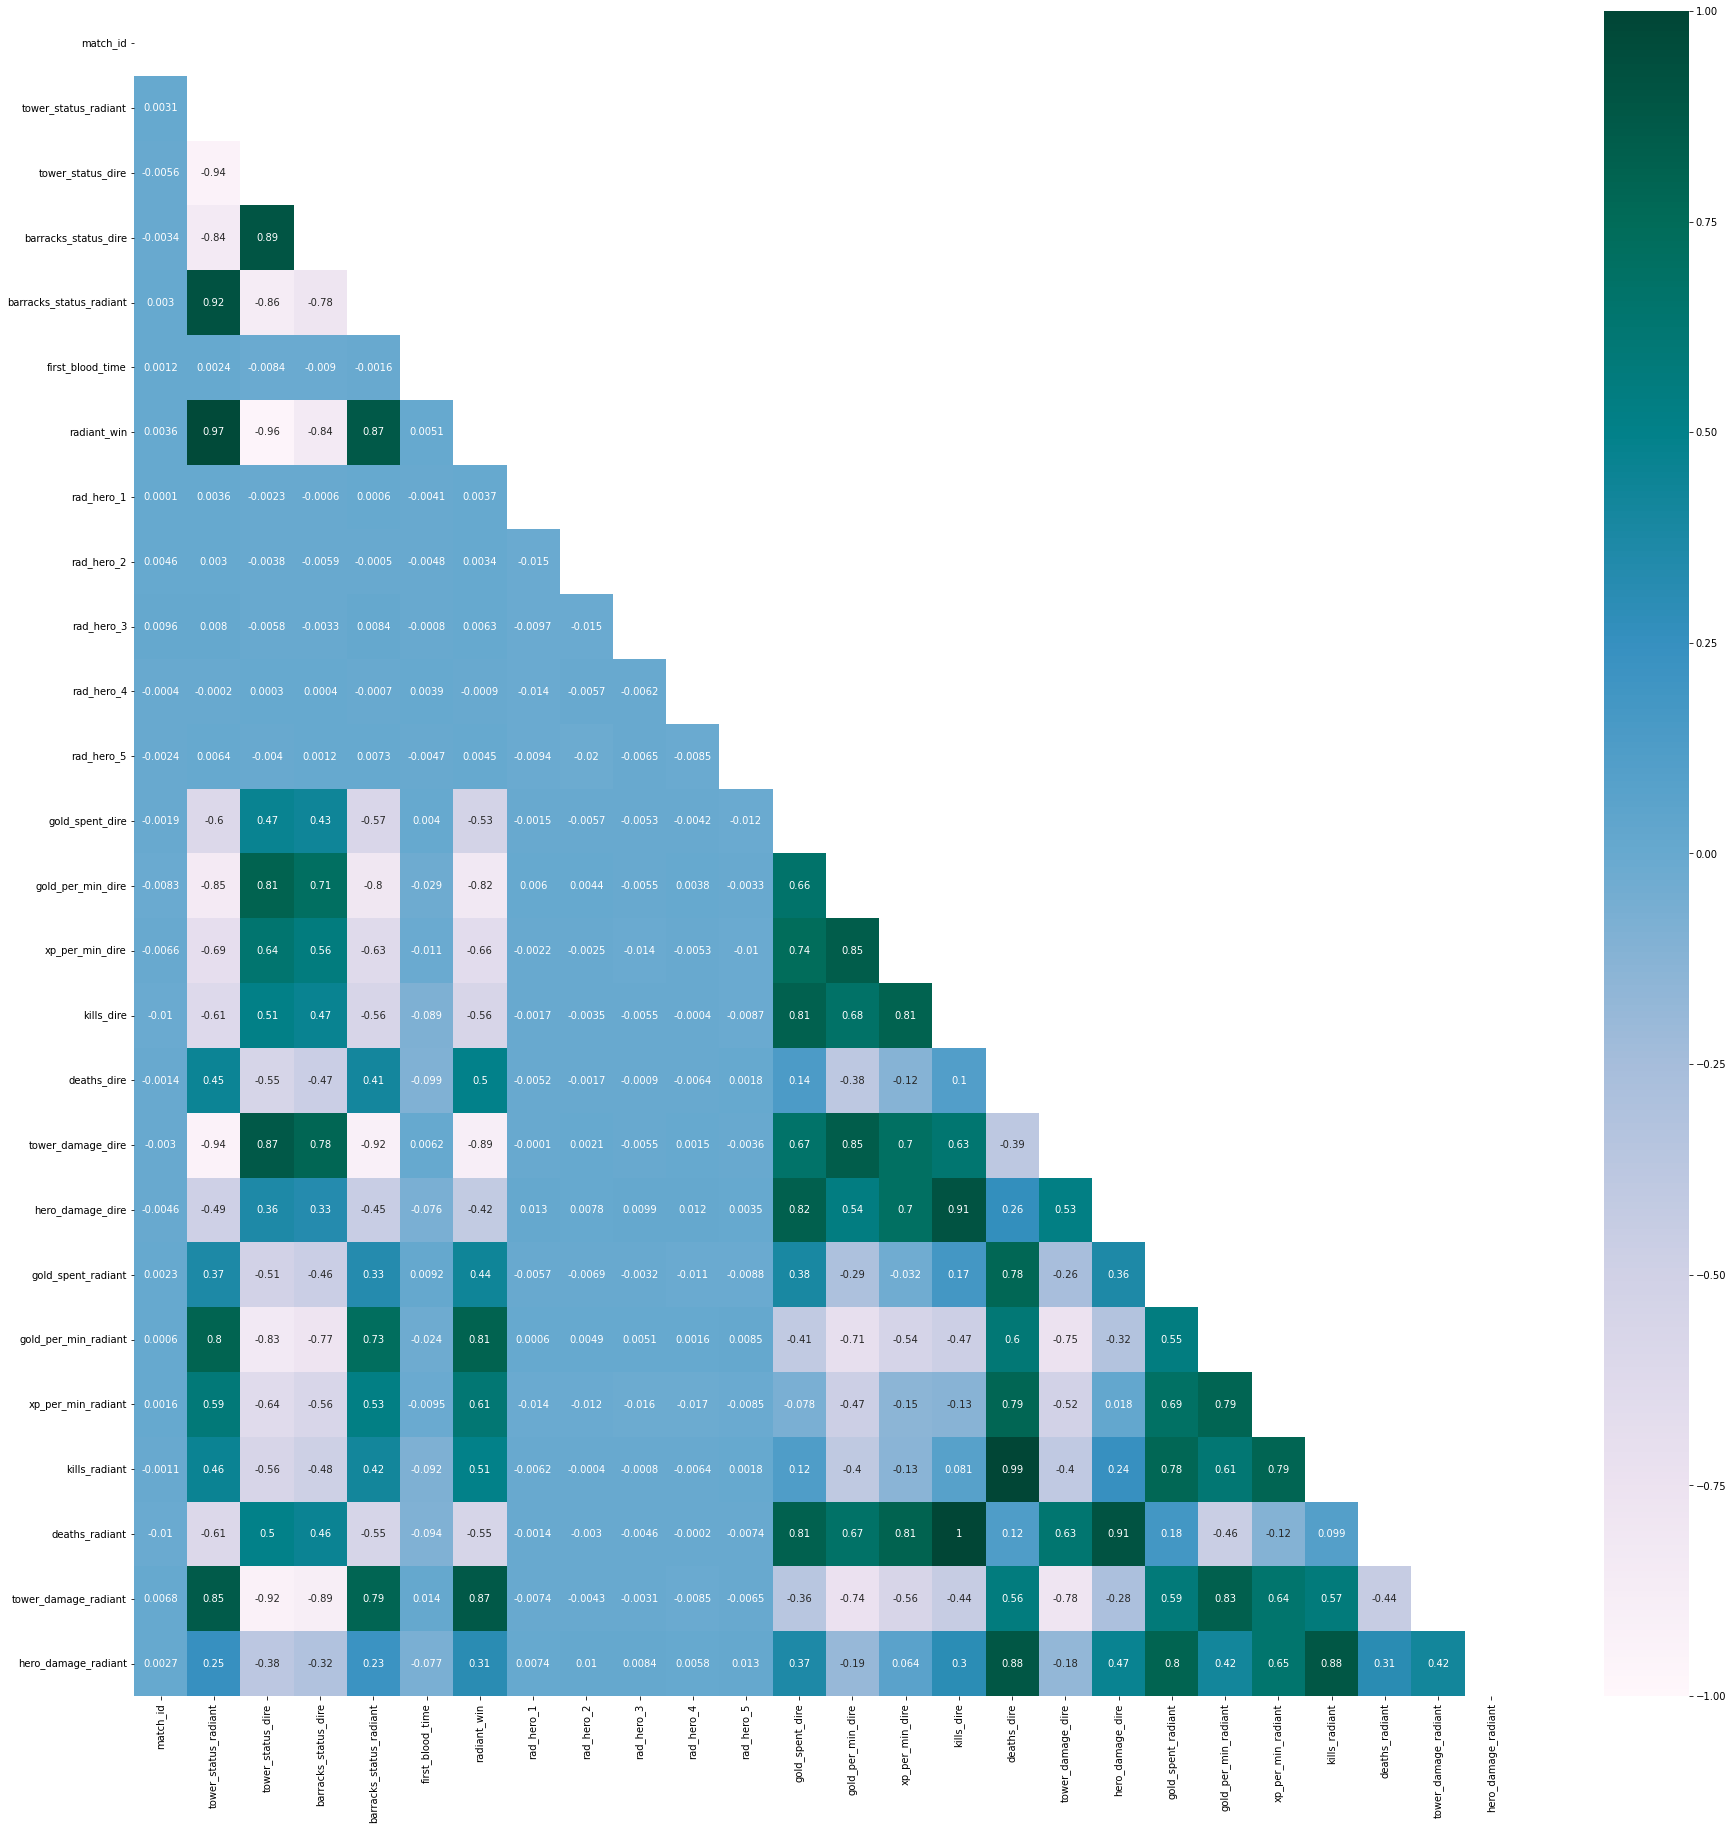

In [6]:
# Check correlation between features
corr = data_matches.corr().round(4)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=((len(data_matches.columns)), (len(data_matches.columns))))
sns.heatmap(corr, annot=True, ax=ax, cmap="PuBuGn", vmin=-1, vmax=1, mask=mask);

In [7]:
# Plot the distribution of the features and correlation
def dist_corr(df, target, col):
    data = df[col].copy()
    name = col
    median = data.median()        

    fig = plt.figure(figsize=(12, 5))
    gs = GridSpec(nrows=1, ncols=2)

    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])

    # Plot distribution 
    sns.histplot(data, kde=True, alpha=0.5, stat='density', ax=ax0, color='plum')
    ax0.set(ylabel='Density', title=name)
    ax0.set_title(f"Distribution: {name}")
    ax0.axvline(median, label=f'Median: {median}', color='black')
    ax0.legend()
    sns.regplot(data=df, x=col, y=target, line_kws={"color": "plum"}, ax=ax1, color='skyblue')
    ax1.set_title(f"Correlation Plot: {name}")
    return fig, gs

(<Figure size 864x360 with 2 Axes>, GridSpec(1, 2))

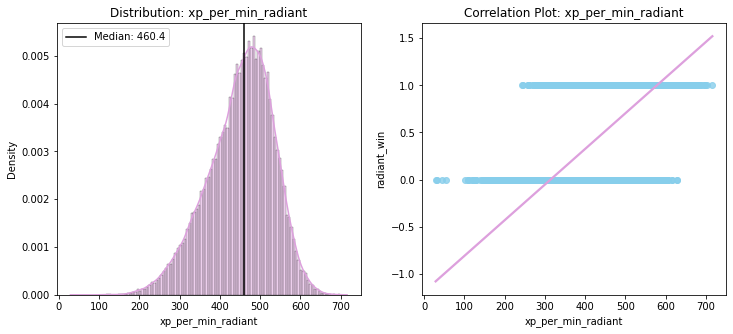

In [8]:
dist_corr(data_matches, 'radiant_win', 'xp_per_min_radiant')

(<Figure size 864x360 with 2 Axes>, GridSpec(1, 2))

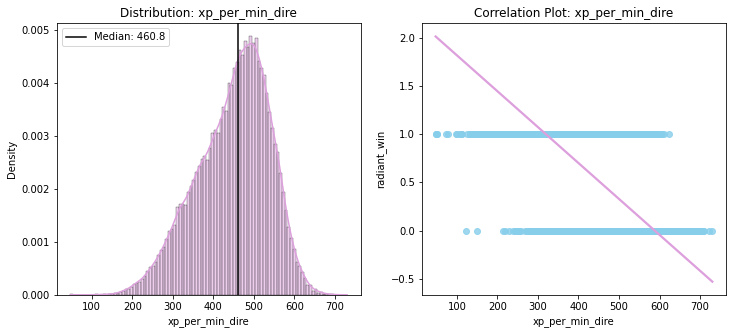

In [9]:
dist_corr(data_matches, 'radiant_win', 'xp_per_min_dire')

We can see that these metrics are really strong predictors for the win.

**Set up win prediction model and data**

In [10]:
# Create feature and target datasets
y = data_matches['radiant_win']
X = data_matches.drop('radiant_win', axis=1)

# Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6220)

# Scale values
cols = X_train.columns
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=cols)
X_test = pd.DataFrame(scaler.transform(X_test), columns=cols)

In [11]:
# Display metrics for the trained models
def print_report(model, X_test, y_train, y_test, name=""):
    y_hat_test = lr_model.predict(X_test)
    y_hat_train = lr_model.predict(X_train)
    
    print(f"Classification Report - Train - {name}")
    print(metrics.classification_report(y_train, y_hat_train))
    print(f"Classification Report - Test - {name}")
    print(metrics.classification_report(y_test,y_hat_test))
    print(f"Confusion matrix and ROC - {name}")

    fig, axes = plt.subplots(ncols=2, figsize=(10,5))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize='true', cmap='Blues', ax=axes[0])
    axes[0].set_title('Confusion Matrix')

    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[1])

    ax = axes[1]
    ax.legend()
    ax.plot([0,1],[0,1], ls='-')
    ax.grid()
    ax.set_title('ROC AUC Curve')

    plt.tight_layout()
    plt.show()

Classification Report - Train - LogisticRegressionCV
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     18043
        True       1.00      1.00      1.00     19457

    accuracy                           1.00     37500
   macro avg       1.00      1.00      1.00     37500
weighted avg       1.00      1.00      1.00     37500

Classification Report - Test - LogisticRegressionCV
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      6014
        True       1.00      1.00      1.00      6486

    accuracy                           1.00     12500
   macro avg       1.00      1.00      1.00     12500
weighted avg       1.00      1.00      1.00     12500

Confusion matrix and ROC - LogisticRegressionCV


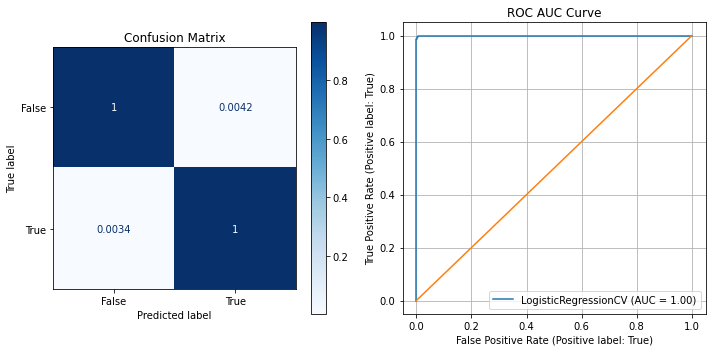

Classification Report - Train - SVC
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     18043
        True       1.00      1.00      1.00     19457

    accuracy                           1.00     37500
   macro avg       1.00      1.00      1.00     37500
weighted avg       1.00      1.00      1.00     37500

Classification Report - Test - SVC
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      6014
        True       1.00      1.00      1.00      6486

    accuracy                           1.00     12500
   macro avg       1.00      1.00      1.00     12500
weighted avg       1.00      1.00      1.00     12500

Confusion matrix and ROC - SVC


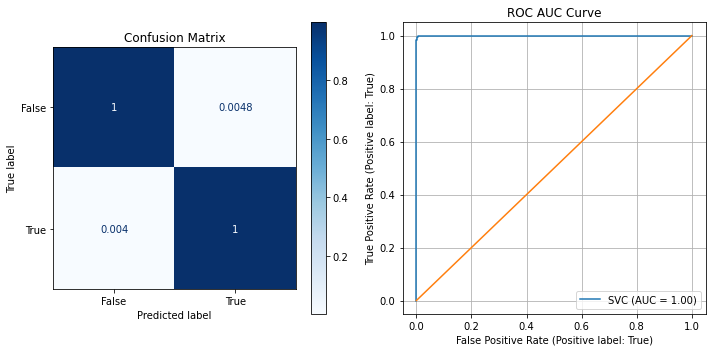

In [12]:
# Train a logistic regression model
lr_model = LogisticRegressionCV()
lr_model.fit(X_train, y_train)

# Train a support vector classifier
svc_model = SVC()
svc_model.fit(X_train, y_train)

print_report(lr_model, X_test, y_train, y_test, "LogisticRegressionCV")
print_report(svc_model, X_test, y_train, y_test, "SVC")